In [1]:
#<GRADED>
import numpy as np
from numpy.matlib import repmat
import sys
import time
import cvxpy as cp
import visclassifier
#</GRADED>
import matplotlib
#matplotlib.use('PDF')
import matplotlib.pyplot as plt


%matplotlib inline

from scipy.stats import linregress

import pylab
from matplotlib.animation import FuncAnimation

%matplotlib notebook

Kernel Matrix:
[[ 5  8 14]
 [ 8 13 23]
 [14 23 41]]


<IPython.core.display.Javascript object>


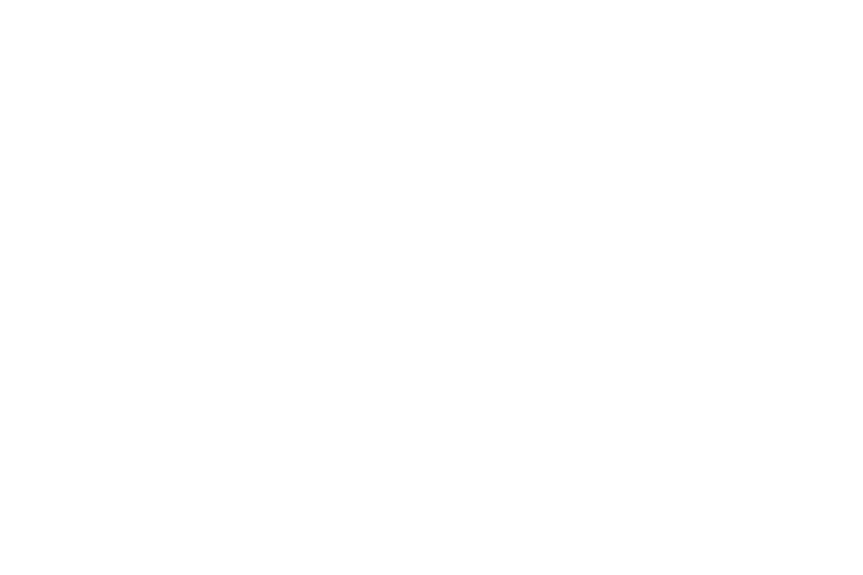

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
X = np.array([[1, 2], [2, 3], [4, 5]])

# Compute the kernel matrix
kernel_matrix = X @ X.T

# Print the kernel matrix
print("Kernel Matrix:")
print(kernel_matrix)

# Plot the kernel matrix
plt.imshow(kernel_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title("Kernel Matrix")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")
plt.show()

In [3]:
plt.close()

In [4]:
import numpy as np
from numpy.matlib import repmat

def l2distance(X, Z=None):
	"""
	function D=l2distance(X,Z)
	
	Computes the Euclidean distance matrix.
	Syntax:
	D=l2distance(X,Z)
	Input:
	X: dxn data matrix with n vectors (columns) of dimensionality d
	Z: dxm data matrix with m vectors (columns) of dimensionality d
	
	Output:
	Matrix D of size nxm
	D(i,j) is the Euclidean distance of X(:,i) and Z(:,j)
	
	call with only one input:
	l2distance(X)=l2distance(X,X)
	"""

	if Z is None:
		## fill in code here
		## << ms2666
		n, d = X.shape
		s1 = np.sum(np.power(X, 2), axis=1).reshape(-1,1)
		D1 = -2 * np.dot(X, X.T) + repmat(s1, 1, n)
		D = D1 + repmat(s1.T, n, 1)
		np.fill_diagonal(D, 0)
		D = np.sqrt(np.maximum(D, 0))
		## >> ms2666
	else:
		## fill in code here
		## << ms2666
		n, d = X.shape
		m, _ = Z.shape
		s1 = np.sum(np.power(X, 2), axis=1).reshape(-1,1)
		s2 = np.sum(np.power(Z, 2), axis=1).reshape(1,-1)
		D1 = -2 * np.dot(X, Z.T) + repmat(s1, 1, m)
		D = D1 + repmat(s2, n, 1)
		D = np.sqrt(np.maximum(D, 0))
		## >> ms2666
	return D

<!--announcements-->
<blockquote>
    <center>
    <img src="yinyang.png" width="400px" /></a>
    </center>
      <p><cite><center>"Just as we have two eyes and two feet,<br>
      duality is part of life."<br>
<b>--Carlos Santana</b><br>
      </center></cite></p>
</blockquote>


<h3>Introduction</h3>
In this project, you will implement a linear support vector machine and one operating in kernel space. For this you will need to formulate the primal and dual optimization problems as quadratic programs. You will be using <code>cvxpy</code>. Before we get started please read through the <a href="http://www.cvxpy.org/en/latest/tutorial/index.html">tutorial</a> of cvxpy and its quadratic programming solver.

<h4> Linear classification</h4>

<p> The first assignment is to implement a linear support vector machine. Before we get started we can generate some data to see if everything is working:  
</p>

In [5]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separagle labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return xTr, yTr

In [6]:
def arrayify(x):
    """flattens and converts to numpy"""
    return np.array(x).flatten()

In [7]:
xTr, yTr = genrandomdata()

<p>Remember the SVM primal formulation
$$\begin{aligned}
             &\min_{\mathbf{w},b,\xi} \|\mathbf{w}\|^2_2+C \sum_{i=1}^n \xi_i\\
       & \text{such that }  \ \forall i:\\
             & y_i(\mathbf{w}^\top \mathbf{x}_i+b)\geq 1-\xi_i\\
             & \xi_i\geq 0.\\
\end{aligned}
$$
You will need to implement  the function <code>primalSVM</code>, which takes in training data <code>xTr</code> ($n\times d$) and labels <code>yTr</code> ($n$) with <code>yTr[i]</code>$\in \{-1,1\}$. Currently, the code below is a placeholder example of a <code>cvxpy</code> optimization problem. You need to update the objective, the constraints and introduce new variables to output the correct hyperplane and bias. </p>

In [8]:
n, d = xTr.shape
w = np.random.randn(d)

In [9]:
w.T @ np.eye(d) @ w

4.35268780218051

In [10]:
#<GRADED>
def primalSVM(xTr, yTr, C=1):
    """
    function (classifier,w,b) = primalSVM(xTr,yTr;C=1)
    constructs the SVM primal formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (n)
        C     | the SVM regularization parameter
    
    Output:
        fun   | usage: predictions=fun(xTe); predictions.shape = (n,)
        wout  | the weight vector calculated by the solver
        bout  | the bias term calculated by the solver
    """
    
    n, d = xTr.shape
    
    # constraints (number of points)
    p, _ = xTr.shape
    
    C = np.array([C]*n)
    
    w = cp.Variable(d) # Rd space features
    b = cp.Variable() # bias term
    Xi = cp.Variable(n) # Slack variables
    
    I = np.eye(d)
    objective = cp.quad_form(w, I) + C.T @ Xi
    
    constraints = [cp.multiply(-yTr, ((xTr @ w) + b)) <= -1 + Xi, -Xi <= np.zeros(n)]
    
    problem = cp.Problem(cp.Minimize(objective), constraints)
    
    problem.solve(verbose=False, solver = 'CVXOPT')
        
    wout = w.value
    bout = b.value
    
    print('\nHyperplane vectors')
    print(wout)
    
    print('\n bias term')
    print(bout)
    
    print('\n objective function value')
    print(problem.value)
    
    print('\n constraints dual problem values (kkt multipliers)')
    print(constraints[0].dual_value)

    fun = lambda xTe: xTe @ wout + bout
    
    return fun, wout, bout
#</GRADED>


Hyperplane vectors
[5.74327291 1.01169123]

 bias term
0.06670245997364226

 objective function value
62.33820335972055

 constraints dual problem values (kkt multipliers)
[2.17608602e-09 2.42955430e-09 2.88588994e-09 4.01670511e-09
 5.03958456e-09 4.21601032e-09 1.30809276e-08 9.99999997e+00
 3.93248481e-09 1.73562564e-08 2.74892473e-09 3.10686517e-09
 1.22184355e-08 4.36697250e-08 9.99999999e+00 4.52093661e-09
 9.50110191e+00 2.62984356e-09 2.92232971e-09 1.16660032e-08
 4.20932646e-09 4.28270528e-09 4.14893081e-08 1.51222493e-08
 2.88942863e-09 1.53601842e-08 9.99999998e+00 2.72652174e-08
 2.64273269e-09 2.95789585e-09 3.92364004e-09 3.46633982e-09
 8.67272656e+00 9.30764455e-09 5.12326755e-09 2.19134218e-09
 1.00000000e+01 3.94881397e-09 5.89776924e-08 8.93173891e-09
 1.35490025e-08 4.89820228e-08 2.47223204e-09 1.19780141e-08
 2.38353425e-09 3.79972719e-09 4.05999345e-08 4.53329447e-09
 6.53868616e-09 4.66282222e-09 2.04649391e-09 3.58632626e-09
 5.43141091e-07 1.17668468e-08 1.5

<IPython.core.display.Javascript object>


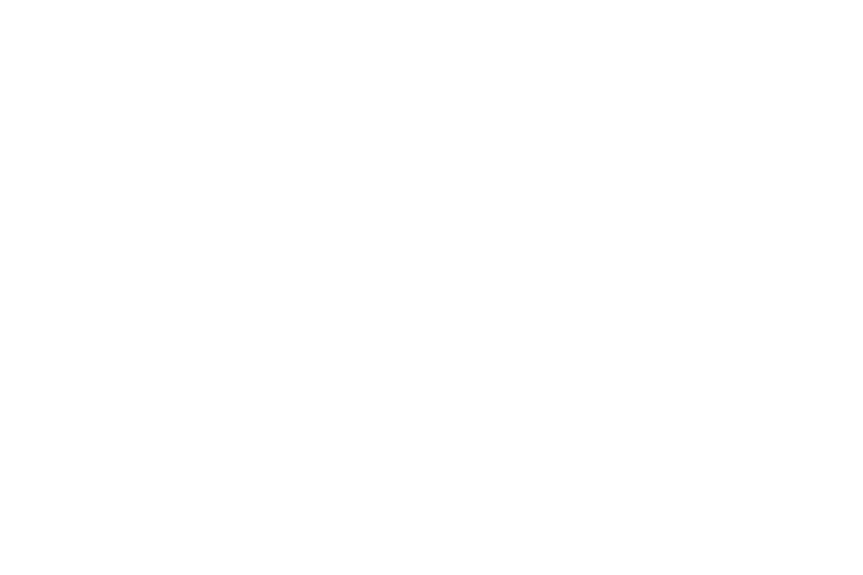

Training error: 0.0%


In [11]:
plt.close()
# We can test your SVM primal solver with the following randomly generated data set. 
#We label it in a way that it is guaranteed to be linearly separable. If your 
#code works correctly the hyper-plane should separate all the $x$'s into 
#the red half and all the $o$'s into the blue half. With sufficiently large values of $C$ 
#(e.g. $C>10$) you should obtain $0\%$ training error. 

xTr,yTr=genrandomdata()
fun,w,b=primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr,w=w,b=b)

err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

In [12]:
plt.close()

### Helper functions used to create animation

In [13]:
def updateboundary():
    global w,b,Xdata,ldata,stepsize

    _, w_pre, b_pre = primalSVM(np.transpose(Xdata),np.array(ldata),C=10)
    w = np.array(w_pre).reshape(-1)
    b = b_pre
    stepsize+=1

def updatescreen():
    global w,b,ax,line 
    q=-b/(w**2).sum()*w;
    if line==None:
        line, = ax.plot([q[0]-w[1],q[0]+w[1]],[q[1]+w[0],q[1]-w[0]],'b--')
    else:
        line.set_ydata([q[1]+w[0],q[1]-w[0]])
        line.set_xdata([q[0]-w[1],q[0]+w[1]])
    
def animate(i):
    if len(ldata)>0:
        if stepsize<1000:
            updateboundary()
            updatescreen();
    
def onclick(event):
    global Xdata, stepsize  
    if event.key == 'shift': # add positive point
        ax.plot(event.xdata,event.ydata,'or')
        label=1
    else: # add negative point
        ax.plot(event.xdata,event.ydata,'ob')
        label=-1    
    pos=np.array([[event.xdata],[event.ydata]])
    ldata.append(label);
    Xdata=np.hstack((Xdata,pos))
    stepsize=1;

### Animation

In [14]:
# Xdata = pylab.rand(2, 0)
# ldata = []
# w = []
# b = []
# line = None
# stepsize = 1

# fig = plt.figure()
# ax = fig.add_subplot(111)
# plt.xlim(0, 1)
# plt.ylim(0, 1)

# cid = fig.canvas.mpl_connect('button_press_event', onclick)
# ani = FuncAnimation(fig, animate, pylab.arange(1, 100, 1), interval=10)

# ani.save('simulation1.mp4', dpi=150, fps=30, writer='ffmpeg', extra_args=['-vcodec', 'libx264'])

# plt.show()

<h4>Spiral data set</h4>

<p>The linear classifier works great in simple linear cases. But what if the data is more complicated? We provide you with a "spiral" data set. You can load it and visualize it with the following two code snippets:
<pre>

In [15]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

<IPython.core.display.Javascript object>


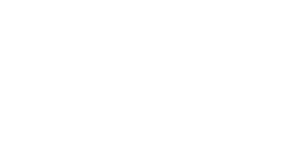

In [16]:
xTr,yTr,xTe,yTe=spiraldata()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

In [17]:
plt.close()

<p>If you apply your previously functioning linear classifier on this data set you will see that you get terrible results. Your training error will increase drastically. </p>

In [18]:
fun,w,b=primalSVM(xTr,yTr,C=1)


Hyperplane vectors
[-0.23691996 -0.01511809]

 bias term
-0.018640813331411935

 objective function value
260.8275096007211

 constraints dual problem values (kkt multipliers)
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00

<IPython.core.display.Javascript object>


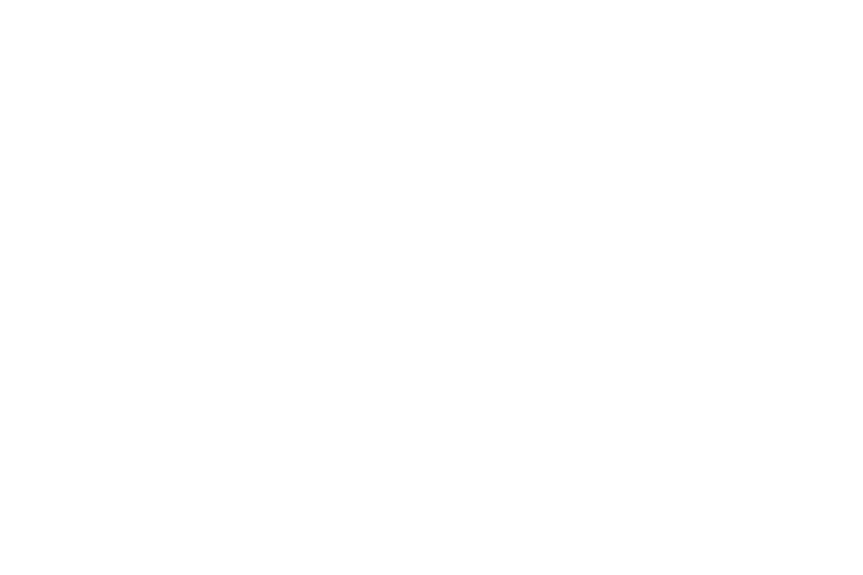

Training error: 39.7%


In [19]:
visclassifier.visclassifier(fun,xTr,yTr,w=[],b=0)
err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

In [20]:
plt.close()

<h3>Implementing a kernelized SVM</h3>

<p> For a data set as complex as the spiral data set, you will need a more complex classifier. 
First implement the kernel function
<pre>	computeK(kerneltype,X,Z,kpar)</pre>
It takes as input a kernel type (kerneltype) and two data sets $\mathbf{X}$ in $\mathcal{R}^{n\times d}$ and $\mathbf{Z}$ in $\mathcal{R}^{m\times d}$ and outputs a kernel matrix $\mathbf{K}\in{\mathcal{R}^{n\times m}}$. The last input, <code>kpar</code> specifies the kernel parameter (e.g. the inverse kernel width $\gamma$ in the RBF case or the degree $p$ in the polynomial case.)
	<ol>
	<li>For the linear kernel (<code>ktype='linear'</code>) svm, use $k(\mathbf{x},\mathbf{z})=x^Tz$ </li> 
	<li>For the radial basis function kernel (<code>ktype='rbf'</code>) svm use $k(\mathbf{x},\mathbf{z})=\exp(-\gamma ||x-z||^2)$ (gamma is a hyperparameter, passed a the value of kpar)</li>
	<li>For the polynomial kernel (<code>ktype='poly'</code>) use  $k(\mathbf{x},\mathbf{z})=(x^Tz + 1)^d$ (d is the degree of the polymial, passed as the value of kpar)</li>
</ol>

<p>You can use the function <b><code>l2distance</code></b> as a helperfunction.</p>





In [21]:
xTr,yTr,xTe,yTe=spiraldata()

In [69]:
#<GRADED>
def computeK(kerneltype, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kerneltype: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel matrix
    """
    assert kerneltype in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kerneltype
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    
    ## Solution Start
    
    
    if kerneltype == 'linear':
        K = X @ Z.T
        
    if kerneltype == 'rbf':
        l2_distance = l2distance(X,Z)
        dist = l2distance(X,Z)**2
        K = np.exp(-kpar*dist)
        
    if kerneltype == 'poly' or kerneltype == 'polynomial':
         K = (X @ Z.T + 1)**kpar
    
    ## Solution End
    return K
#</GRADED>b

<IPython.core.display.Javascript object>


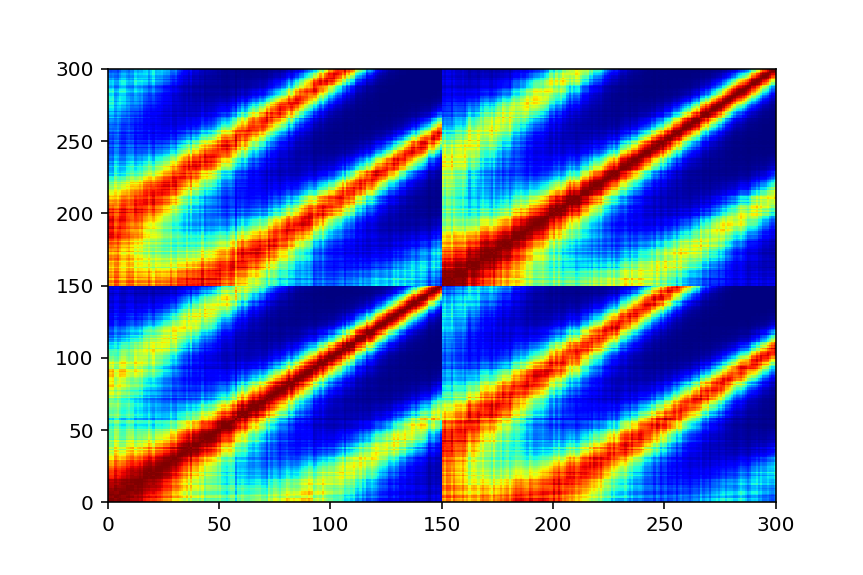

In [70]:
plt.close()
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
# print(K)
# plot an image of the kernel matrix
plt.pcolormesh(K, cmap='jet')
plt.show()

<p>The following code snippet plots an image of the kernel matrix for the data points in the spiral set. Use it to test your <b><code>computeK</code></b> function:</p>

Remember that the SVM optimization has the following dual formulation:
$$
\begin{aligned}
             &\min_{\alpha_1,\cdots,\alpha_n}\frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{K}_{ij} - \sum_{i=1}^{n}\alpha_i  \\
       \text{s.t.}  &\quad 0 \leq \alpha_i \leq C\\
             &\quad \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}
$$
This is equivalent to solving for the SVM primal
$$ L(\mathbf{w},b) = C\sum_{i=1}^n \max(1-y_i(\mathbf{w}^\top\phi(\mathbf{x}_i)+b),0) + ||w||_2^2$$
where $\mathbf{w}=\sum_{i=1}^n y_i \alpha_i \phi(\mathbf{x}_i)$ and $\mathbf{K}_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)=\phi(\mathbf{x}_i)^\top\phi(\mathbf{x}_j)$, for some mapping $\phi(\cdot)$.  Please note that here all $\alpha_i\geq 0$, which is possible because we multiply by $y_i$ in the definition of $\mathbf{w}$. One advantage of keeping all $\alpha_i$ non-negative is that we can easily identify non-support vectors as vectors with $\alpha_i=0$. 

<p>Implement the function <code>dualqp</code>, which takes as input a kernel matrix $K$, a vector of labels $yTr$ in $\mathcal{R}^{n}$, and a regularization constant $C\geq 0$. This function should solve the quadratic optimization problem and output the optimal vector $\mathbf{\alpha}\in{\mathcal{R}^n}$.</p>



In [71]:
#<GRADED>
def dualqp(K,yTr,C):
    """
    function alpha = dualqp(K,yTr,C)
    constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        K     | the (nxn) kernel matrixa
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
    
    Output:
        alpha | the calculated solution vector (nx1)
    """
    
    n, _ = K.shape
    
    alpha = cp.Variable(n)
    
    ONE = np.ones(n)
    
#     Q = np.diag(np.multiply(np.outer(yTr, yTr), K))
#     objective = 0.5*(cp.quad_form(alpha, Q)) - ONE.T @ alpha

    objective = cp.Minimize(0.5*(cp.quad_form(cp.multiply(alpha, yTr), K)) - (ONE.T @ alpha))
    
    constraints = [
        alpha >= 0, 
        alpha <= C, 
        yTr.T * alpha == 0]
    
    problem = cp.Problem(objective,constraints)
    
    problem.solve(verbose=False, solver = 'CVXOPT')
    
    alphas = np.array(alpha.value)
    
    return alphas.flatten()
    
    ## Solution End
    
#</GRADED>

The following code shows a usecase of how <code>dualqp</code> could be used in practice. 

In [72]:
C = 10
lmbda = 0.25
ktype = "rbf"
xTr,yTr,xTe,yTe=spiraldata()
# compute kernel (make sure it is PSD)
# K = computeK(ktype,xTr,xTr)
K = computeK(ktype, xTr, xTr, C)
eps = 1e-10
# make sure it is symmetric and positive semi-definite
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])

alpha=dualqp(K,yTr,C)
print(np.min(alpha))
print(np.max(alpha))

/Users/vpb/anaconda3/envs/ds/lib/python3.8/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 7 times so far.

  warnings.warn(msg, UserWarning)


2.555686325166385e-07
1.0140499791751318


<p> Now that you can solve the dual correctly, you should have the values for $\alpha_i$. But you are not done yet. You still need to be able to classify new test points. Remember from class that $h(\mathbf{x})=\sum_{i=1}^n \alpha_i y_i k(\mathbf{x}_i,\mathbf{x})+b$. You need to obtain $b$. It is easy to show (and omitted here) that if $C>\alpha_i>0$ (with strict $>$), then we must have that $y_i(\mathbf{w}^\top \phi(\mathbf{x}_i)+b)=1$. Rephrase this equality in terms of $\alpha_i$ and solve for $b$. Implement

<p> b=recoverBias(K,yTr,alphas,C); </p>

<p> where <code>b</code> is the hyperplane bias.
(Hint: This is most stable if you pick an $\alpha_i$ that is furthest from $C$ and $0$. )</p>

<p>Please note that this use of the word bias has absolutely nothing to do with the word bias in the bias variance trade-off. It is just the same word but two completely different meanings. This unfortunate term collision comes from the fact that we are borrowing concepts from geometry and statistics.</p>

In [90]:
#<GRADED>
def recoverBias(K,yTr,alpha,C):
    """
    function bias=recoverBias(K,yTr,alpha,C);
    Solves for the hyperplane bias term, which is uniquely specified by the 
    support vectors with alpha values 0<alpha<C
    
    INPUT:
    K : nxn kernel matrix
    yTr : nx1 input labels
    alpha  : nx1 vector of alpha values
    C : regularization constant
    
    Output:
    bias : the scalar hyperplane bias of the kernel SVM specified by alphas
    """
    
    n = yTr.shape[0]
    
    one = np.ones(n)
    
    phi_x = np.diag(K)
    
    biases = np.divide(one,yTr) - np.multiply(np.multiply(yTr,alpha),phi_x)
    
    bias = np.median(biases)
    
    return bias
    
    

    ## Solution Start
#</GRADED>

<p> Test your <b><code>recoverBias</code></b> function with the following code, which uses the dual solver on a linearly separable dataset:</p>

In [91]:
xTr,yTr=genrandomdata(b=0.5)
C=10
K=computeK("linear",xTr,xTr)
eps=1e-5
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])
alpha = dualqp(K,yTr,C)
ba=recoverBias(K,yTr,alpha,C)
print(ba)

1.0


/Users/vpb/anaconda3/envs/ds/lib/python3.8/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 18 times so far.

  warnings.warn(msg, UserWarning)


/Users/vpb/anaconda3/envs/ds/lib/python3.8/site-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 19 times so far.

  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


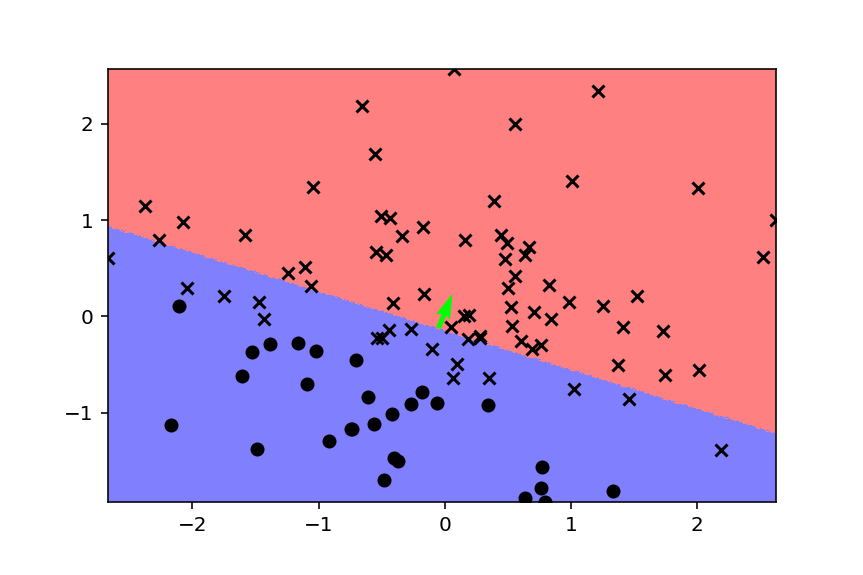

In [92]:
plt.close()
xTr,yTr=genrandomdata(b=0.5)
C=10
K=computeK("linear",xTr,xTr)
eps=1e-5
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])
alpha = dualqp(K,yTr,C)
ba=recoverBias(K,yTr,alpha,C)
wa = (alpha * yTr).dot(xTr)
fun = lambda x: x.dot(wa) + ba
visclassifier.visclassifier(fun, xTr, yTr, w=wa, b=ba)
plt.show()

<p>
    Implement the function 
    <pre>
    svmclassify=dualSVM(xTr,yTr,C,ktype,kpar);
    </pre>
    It should use your functions <code><b>computeK</b></code> and <code><b>generateQP</b></code> to solve the SVM dual problem of an SVM specified by a training data set (<code><b>xTr,yTr</b></code>), a regularization parameter (<code>C</code>), a kernel type (<code>ktype</code>) and kernel parameter (<code>lmbda</code>, to be used as kpar in Kernel construction). Then, find the support vectors and recover the bias to return <b><code>svmclassify</code></b>, a function that uses your SVM to classify a set of test points <code>xTe</code>.

<b>Hint: You need to ensure that the kernel matrix is positive semi-definite during training. The best way to do this is to make sure it is strictly symmetric and to add the identity matrix to it, multiplied by a tiny epsilon value.</b>
    
</p>


In [ ]:
#<GRADED>
def testkernel(X,Z,kpar):
    D = (l2distance.l2distance(X, Z))**2
    expo = -D * (kpar)
#         print(expo[0][:20])
    K = np.exp(expo)
def dualSVM(xTr,yTr,C,ktype,lmbda,eps=1e-10):
    """
    function classifier = dualSVM(xTr,yTr,C,ktype,lmbda);
    Constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Input:
        xTr   | training data (nxd)
        yTr   | training labels (nx1)
        C     | the SVM regularization parameter
        ktype | the type of kernelization: 'rbf','polynomial','linear'
        lmbda | the kernel parameter - degree for poly, inverse width for rbf
    
    Output:
        svmclassify | usage: predictions=svmclassify(xTe);
    """
    
    
    # Solution Start
#</GRADED>

<p>Now we try the SVM with RBF kernel on the spiral data. If you implemented it correctly, train and test error should be close to zero.</p>

In [ ]:
xTr,yTr,xTe,yTe=spiraldata()
C=10.0
sigma=0.25
ktype="rbf"
svmclassify=dualSVM(xTr,yTr,C,ktype,sigma)

visclassifier.visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=np.mean(np.sign(predsTr)!=yTr)
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=np.mean(np.sign(predsTe)!=yTe)
print("Testing error: %2.4f" % testingerr)

SVMs are pretty sensitive to hyper-parameters. We can visualize the results of a hyper-parameter grid search as a heat-map, where we sweep across different values of C and kpar and output the result on a validation dataset. Now we ask you to implement a cross-validation function.

In [ ]:
#<GRADED>
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        ErrorMatrix| the test error rate for each given C and Lmbda when trained on (xTr,yTr) and tested on (xValid,yValid),(axb)
    """
    # gridsearch for best parameters
    ErrorMatrix=np.zeros((len(CList),len(lmbdaList)))
    bestC,bestLmbda = 0.,0.
    
    # Start Solution
    min_error=float('inf')
    for i in range(len(CList)):
        C = CList[i]
        for j in range(len(lmbdaList)):
            lmbda=lmbdaList[j]
            svmclassify = dualSVM(xTr,yTr,C,ktype,lmbda)
            pre = svmclassify(xValid)
            error = np.mean(np.sign(pre) != yValid)
            ErrorMatrix[i, j] = error
            if error < min_error:
                min_error = error
                bestC = C
                bestlmbda = lmbda
    # End Solution
            
    return bestC,bestLmbda,ErrorMatrix
#</GRADED>

In [ ]:
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-1,5,7))
lmbdaList=(np.linspace(0.1,0.5,5))

bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList)

plt.pcolormesh(ErrorMatrix, cmap='jet')
plt.colorbar()
plt.xlabel("lmbda_idx")
plt.ylabel("C_idx")
plt.title("Validation error")

If you implemented everything correctly, the result should look similar to this image:
<center>
 <img src="crossval.png" width="300px" />
</center>

Competition: we ask you to implement function autosvm, which given xTr and yTr, splits them into training data and validation data, and then uses a hyperparameter search to find the optimal hyper parameters. 

Function autosvm should return a function which will act as a classifier on xTe.

You have a 5 minute time limit on multiple datasets, each dataset having different optimal hyperparameters, so you should strive for a good method of finding hyperparameters (within the time limit) instead of just trying to find a static set of good hyperparameters. 

You will get extra credit for the competition if you can beat the base benchmark of 34% error rate.

In [ ]:
#<GRADED>
def autosvm(xTr,yTr):
    """
    svmclassify = autosvm(xTr,yTr), where yTe = svmclassify(xTe)
    
     cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList)
    
    """


    # (Optional) TODO 7

#</GRADED>

In [ ]:
length=xTr.shape[0]
p=np.random.permutation(len(xTr))
m=0.8*length
n=length
trn_idx=p[:m]
tst_idx=p[m:]
xtrn = xTr[trn_idx]
ytrn = yTr[trn_idx]
xval = xTr[tst_idx]
yval = yTr[tst_idx]
x=np.zeros(m,2)
y=np.zeros(m,1)
ktype="rbf"
def computeerror(xtrn,ytrn,xval,yval,x):
     svmclassify = dualSVM(xtrn,ytrn,x[0],"rbf",x[1])
     pre = svmclassify(xval)
     error = np.mean(np.sign(pre) != yval)
     return error
for i in range (0,m):
    x[i,0]=np.random.uniform(0,100) #c
    x[i,1]=np.random.uniform(0, 1)  #lmbda
    y[i]=computeerror(xtrn,ytrn,xval,yval,x[i])
K=computeK(ktype, x[:m],x[:m])
for i in range(m,n):
    
    K1=computeK(ktype, x[:m], x[m:i+1])
    K2=computeK(ktype,x[m:i+1],x[m:i+1])
    d=arg(K1.T.dot(np.linalg.inv(K))).dot(y)-0.1*np.sqrt(K2-(K1.T.dot(np.linalg.inv(K))).dot(K1))
    
    y[i]=computeerror(xtrn,ytrn,xval,yval,x[i])
    x[i-1]=np.min(x[:i-1])-


    
    

In [ ]:
print(len(xTr))